## Unsupervised Learning Applications

## Customer Segmentation

Customer segmentation is simply a way of arranging your customers into smaller groups/segment according to certain characteristics/attribute. In oorder to target specific, relevant marketing messages at each group.

The Original data set is from the Kaggle 'Online Retail Data Set II' provided by UCL.

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

This Data has been transformed in previous Kernel (https://www.kaggle.com/odezi45/customer-segmentation-using-rfm-analysis), so I will just quickly run through it here.

## Import Libraries

In [36]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from datetime import *
import matplotlib
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn.cluster import MeanShift , estimate_bandwidth
%matplotlib inline

## Import Data and Perform all Pre-Processing Task

In my previous kernel, I already process the data and conducted RFM Analysis. In this post, I will applying various clustering method from scikit-learn on the already processed data.

In [37]:
sales = pd.read_csv('online_retail_II.csv')

# convert InvoiceDate column to the right format
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'])

# From the descriptive statistics, we can see some negative values in Quantity and Price, so Lets have a look
negprice = sales[sales['Price'] < 0]
negquantity = sales[sales['Quantity'] < 0]

## take out negative price from the sales data
sales = sales[sales['Price']>= 0]

## we have also identify some descriptions that doesnt look like sales
sales2 = sales[sales['Description'].isin(['?',
'?????',
'back charges',
'bad quality',
'Came as green?',
'Came as green?',
'cant find',
'cant find',
'check',
'checked',
'checked',
'code mix up 72597',
'code mix up 72597',
'coding mix up',
'crushed',
'crushed',
'damaged',
'damaged/dirty',
'damaged?',
'damages',
'damages etc',
'damages, lost bits etc',
'damages?',
'damges',
'Damp and rusty',
'dirty',
'dirty, torn, thrown away.',
'display',
'entry error',
'faulty',
'for show',
'given away',
'gone',
'Gone',
'incorrect credit',
'lost',
'lost in space',
'lost?',
'missing',
'Missing',
'missing (wrongly coded?)',
'missing?',
'missings',
'reverse mistake',
'Rusty ',
'Rusty connections',
'show',
'show display',
'smashed',
'sold in wrong qnty',
'This is a test product.',
'used for show display',
'wet',
'wet & rotting',
'wet and rotting',
'wet cartons',
'wet ctn',
'wet damages',
'Wet, rusty-thrown away',
'wet/smashed/unsellable',
'wrong code',
'wrong ctn size',
'Zebra invcing error'])]

## so lets take those spurious sales out
sales = sales[~sales.apply(tuple,1).isin(sales2.apply(tuple,1))]

## About 20% of the dataset has missing customer ID and 0.4% of the dataset has no description
# SO I willa ssume that the missing customer id are 9999 and the description is 'Unlnown'

sales[['Customer ID']] =sales[['Customer ID']].fillna(99999)
sales[['Description']] =sales[['Description']].fillna('Unknown')

# lets also take out all negative quantity as, they are either returns or errors in the data.
sales = sales[sales['Quantity'] > 0]
sales = sales[sales['Customer ID'] != 99999]

## Now Lets find the first and second time a customer ordered by aggregating the values
sales_ = sales.groupby('Invoice').agg(
    Customer =('Customer ID', 'first'),
    InvoiceDate2=('InvoiceDate', 'min'))
sales_.reset_index(inplace = True)
sales_['daterank'] = sales_.groupby('Customer')['InvoiceDate2'].rank(method="first", ascending=True)

# find customers second purchase and name dataframe sales_
sales_ = sales_[sales_['daterank']== 2]
sales_.drop(['Invoice', 'daterank'], axis=1, inplace=True)
sales_.columns = ['Customer ID', 'InvoiceDate2']

# Lets Aggregate the data to find certain customer metrics 
sales['amount'] = sales['Price'] * sales['Quantity']
salesgroup = sales.groupby('Customer ID').agg(
    Country=('Country', 'first'),
    sum_price=('Price', 'sum'),
    sum_quantity=('Quantity', 'sum'),
    max_date=('InvoiceDate', 'max'),
    min_date=('InvoiceDate', 'min'),
    count_order=('Invoice', 'nunique'),
    avgitemprice=('Price', 'mean'),
    monetary =('amount', 'sum'),
    count_product=('Invoice', 'count'))

salesgroup.reset_index(inplace = True)


#Find the max date of this study
maxdate = sales['InvoiceDate'].max()

#Calculate AOV. Item per basket
salesgroup['avgordervalue'] = salesgroup['monetary']/salesgroup['count_order']
salesgroup['itemsperbasket'] = salesgroup['sum_quantity']/salesgroup['count_order']

# join the data with the dataframe containing customer id with 2nd visits
salesgroup = pd.merge(salesgroup, sales_ , how='left', on=['Customer ID'])

# find difference between first purchase and 2nd purchase 
salesgroup['daysreturn']  = salesgroup['InvoiceDate2']- salesgroup['min_date']
salesgroup['daysreturn'] = salesgroup['daysreturn']/np.timedelta64(1,'D')
salesgroup['daysmaxmin']  = salesgroup['max_date']- salesgroup['min_date']
salesgroup['daysmaxmin'] = (salesgroup['daysmaxmin']/np.timedelta64(1,'D'))+1

#calculate Frequency and Recency
salesgroup['frequency'] = np.where(salesgroup['count_order'] >1,salesgroup['count_order']/salesgroup['daysmaxmin'],0)
salesgroup['recency']  = maxdate- salesgroup['max_date']
salesgroup['recency'] = salesgroup['recency']/np.timedelta64(1,'D')

# Now we have the values for Recency, Frequency and Monetary parameters. Each customer will get a note between 1 and 4 for each parameter.
#By Applying quantile method we group each quantile into 25% of the population. 

#so letsdefine the quantile and save it ina dictionary
quintiles2 = salesgroup[['recency', 'frequency', 'monetary']].quantile([.2, .4, 0.6, .8]).to_dict()

def r_score2(y):
    if y <= quintiles2['recency'][.2]:
        return 5
    elif y <= quintiles2['recency'][.4]:
        return 4
    elif y <= quintiles2['recency'][.6]:
        return 3
    elif y <= quintiles2['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score2(y, k):
    if y <= quintiles2[k][.2]:
        return 1
    elif y <= quintiles2[k][.4]:
        return 2
    elif y <= quintiles2[k][.6]:
        return 3
    elif y <= quintiles2[k][.8]:
        return 4
    else:
        return 5    

#lets get the RFM values by calling the function above

salesgroup['R2'] = salesgroup['recency'].apply(lambda y: r_score2(y))
salesgroup['F2'] = salesgroup['frequency'].apply(lambda y: fm_score2(y, 'frequency'))
salesgroup['M2'] = salesgroup['monetary'].apply(lambda y: fm_score2(y, 'monetary'))

salesgroup['RFM Score2'] = salesgroup['R2'].map(str) + salesgroup['F2'].map(str) + salesgroup['M2'].map(str)
salesgroup['RFM Score2'] = salesgroup['RFM Score2'].astype(int)


def mapl(salesgroup, r_rule, fm_rule, label, colname='new_label'):
    salesgroup.loc[(salesgroup['R2'].between(r_rule[0], r_rule[1]))
            & (salesgroup['F2'].between(fm_rule[0], fm_rule[1])), colname] = label
    return salesgroup

salesgroup['new_label'] = ''

salesgroup = mapl(salesgroup, (4,5), (4,5), 'Champions')
salesgroup = mapl(salesgroup, (2,5), (3,5), 'Loyal customers')
salesgroup = mapl(salesgroup, (3,5), (1,3), 'Potential loyalist')
salesgroup = mapl(salesgroup, (4,5), (0,1), 'New customers')
salesgroup = mapl(salesgroup, (3,4), (0,1), 'Promising')
salesgroup = mapl(salesgroup, (2,3), (2,3), 'Needing attention')
salesgroup = mapl(salesgroup, (2,3), (0,2), 'About to sleep')
salesgroup = mapl(salesgroup, (0,2), (2,5), 'At risk')
salesgroup = mapl(salesgroup, (0,1), (4,5), 'Cant loose them')
salesgroup = mapl(salesgroup, (1,2), (1,2), 'Hibernating')
salesgroup = mapl(salesgroup, (0,2), (0,2), 'Lost')



In [38]:
sales_cleansed = salesgroup[['Customer ID', 'Country', 'sum_price', 'sum_quantity', 'monetary',
        'frequency', 'recency','R2', 'F2', 'M2','RFM Score2', 'new_label']]


Now we have a preped dataset, lets start applying some clustering methodology

Text(0.5, 0, 'Customer Attributes')

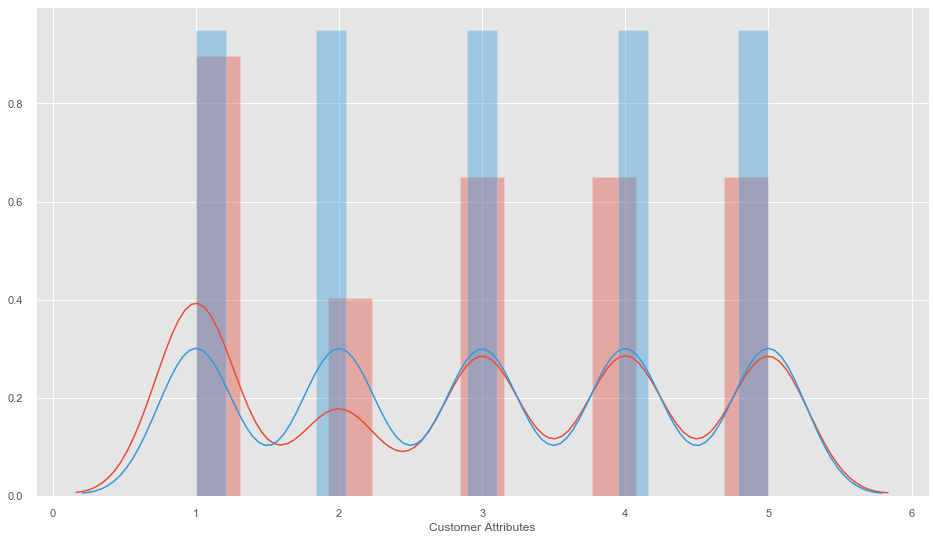

In [39]:
# Plot styling
plt.rcParams['figure.figsize'] = (16, 9)
mpl.style.use('ggplot') # for ggplot-like style
# let us Visualize the existing data
plot_frequency=sns.distplot(sales_cleansed['F2'], color="#e74c3c")
plot_monetary=sns.distplot(sales_cleansed['M2'], color="#3498db")
plt.xlabel('Customer Attributes')

## Prepare data frame with columns for clustering

In [40]:
sales_cl = sales_cleansed[[ 'monetary','frequency', 'recency']] #3 column attributes
sales_cl2 = sales_cleansed[[ 'monetary','frequency']] #2 column attributes

## Scaled data to standardize

In [41]:
# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(sales_cl)
sales_scaled = scaler.transform(sales_cl)

scaler.fit(sales_cl2)
sales_scaled2 = scaler.transform(sales_cl2)

## K-means model

K-means works by grouping the points together in such a way that the distance between all the points and the midpoint of the cluster they belong to is minimized.

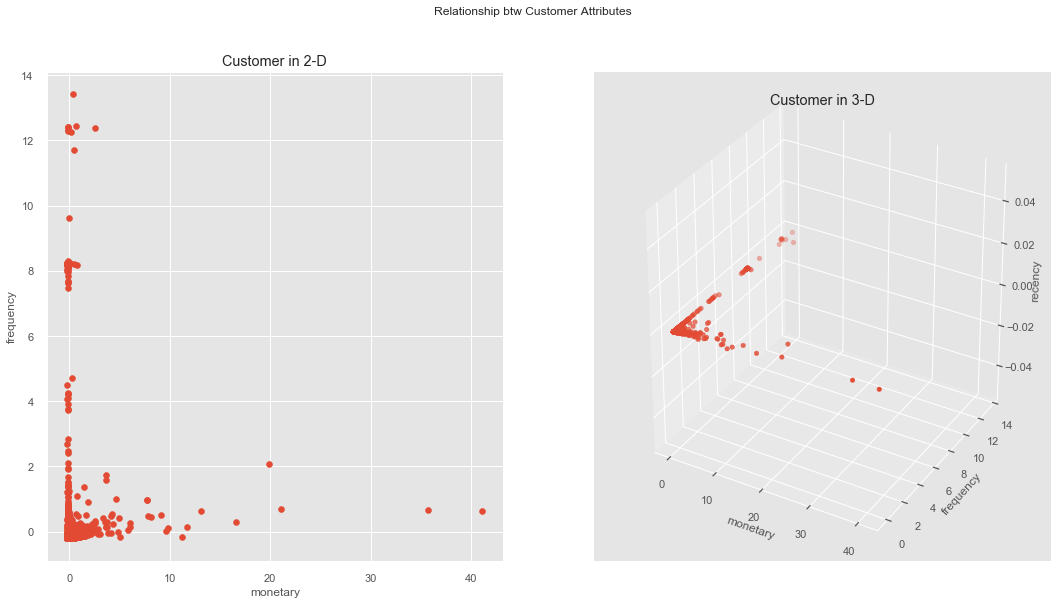

In [42]:
# let visualise a 3-D of the monetary, frequency & recency of each customer
from mpl_toolkits.mplot3d import Axes3D

# Set up a figure twice as tall as it is wide
fig = plt.figure(figsize=(18, 9))
fig.suptitle('Relationship btw Customer Attributes')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1])
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1]) #, sales_scaled[:, 2]) #, sales_scaled[:, 2])
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Customer in 3-D')

plt.show()

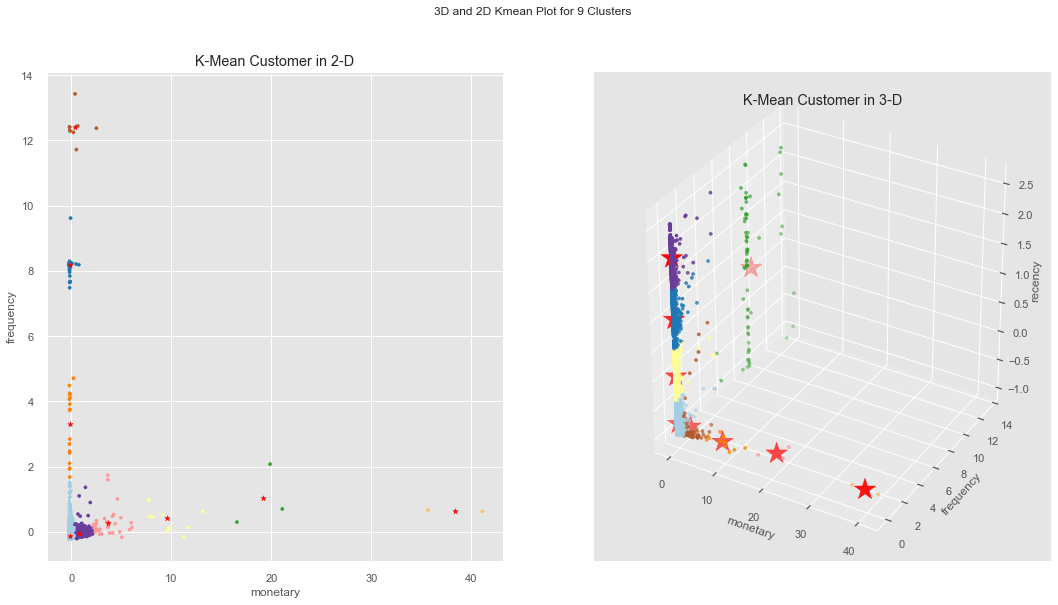

In [43]:
# Initializing K-Means with 9 clusters
kmeans = KMeans(n_clusters=9)
# Fitting with inputs
kmean3D = kmeans.fit(sales_scaled)
# Predicting the clusters
labels3D = kmean3D.predict(sales_scaled)
# Getting the cluster centers
C3D = kmean3D.cluster_centers_
##################################################################################################
kmean2D = kmeans.fit(sales_scaled2)
# Predicting the clusters
labels2D = kmean2D.predict(sales_scaled2)
# Getting the cluster centers
C2D = kmean2D.cluster_centers_


# visualise the 6 cluster k_mean
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Kmean Plot for 9 Clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.scatter(C2D[:, 0], C2D[:, 1], marker='*', c='red', s=30)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('K-Mean Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.scatter(C3D[:, 0], C3D[:, 1], C3D[:, 2], marker='*', c='red', s=500)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('K-Mean Customer in 3-D')

plt.show()

## Parameter Tuning for K-Mean to find Optimum Clusters

<Figure size 864x576 with 0 Axes>

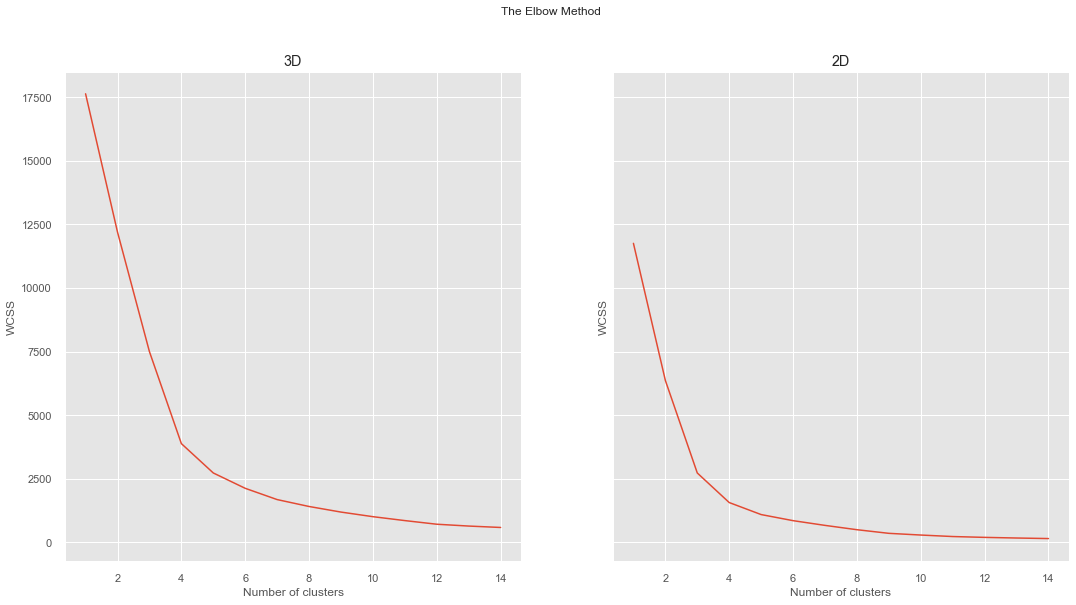

In [44]:
# finding the best number of clusters
# WCSS measures sum of distances of observations from their cluster centroids which is given by the below formula.
# by plotting the Within Cluster Sum Of Squares (WCSS) against the the number of clusters (K Value) 
# then we can identify the optimal number of clusters value. 
plt.figure(figsize=(12, 8))

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 412)
    kmeans.fit(sales_scaled)
    wcss.append(kmeans.inertia_)
wcss2 = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 412)
    kmeans.fit(sales_scaled2)
    wcss2.append(kmeans.inertia_)
    
    
fig, axs = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
fig.suptitle('The Elbow Method')
axs[0].plot(range(1, 15), wcss)
axs[0].set_title('3D')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')

axs[1].plot(range(1, 15), wcss2)
axs[1].set_title('2D')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('WCSS')

plt.show()

## Updating K-Means with optimum cluster derived through the elbow method

In [45]:
# Fitting K-Means to the dataset using 4 clusters
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(sales_scaled)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
labels3D=y_kmeans+1
# New Dataframe called cluster
cluster3D = pd.DataFrame(labels3D)
# centroid 
C3D = kmeans.cluster_centers_
# Adding cluster to the Dataset1
#sales_cleansed['cluster'] = cluster
#################################################################################################

# Fitting K-Means to the dataset using 4 clusters
kmeans2D = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans2D = kmeans2D.fit_predict(sales_scaled2)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans12D=y_kmeans2D
labels2D=y_kmeans2D+1
# New Dataframe called cluster
cluster2D = pd.DataFrame(labels2D)
# centroid 
C2D = kmeans2D.cluster_centers_

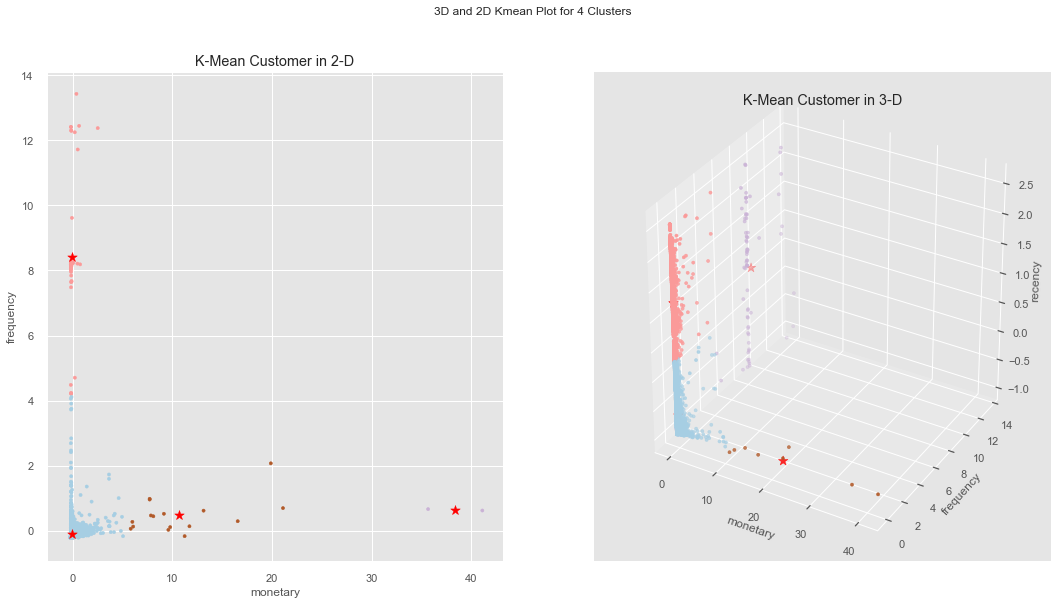

In [46]:
# Plot the output of 4 clusters in 3-Dimension
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Kmean Plot for 4 Clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.scatter(C2D[:, 0], C2D[:, 1], marker='*', c='red', s=100)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('K-Mean Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.scatter(C3D[:, 0], C3D[:, 1], C3D[:, 2], marker='*', c='red', s=100)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('K-Mean Customer in 3-D')

plt.show()

## Mean shift clustering algorithm

## What is Meanshift?
Meanshift is a clustering algorithm that assigns the datapoints to the clusters iteratively by shifting points towards the mode. The mode can be understood as the highest density of datapoints (in the region, in the context of the Meanshift).
please refer to http://www.chioka.in/meanshift-algorithm-for-the-rest-of-us-python/ for more info.

In [47]:
# #############################################################################
# Compute clustering with MeanShift default parameter

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(sales_scaled, quantile=0.2, n_samples=5870)

msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msc.fit(sales_scaled)
labels3D = msc.labels_
C3D = msc.cluster_centers_
labels_unique = np.unique(labels3D)
n_clusters_ = len(labels_unique)

print("number of estimated meanshift clusters 3D : %d" % n_clusters_)

# #############################################################################

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(sales_scaled2, quantile=0.2, n_samples=5870)

msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msc.fit(sales_scaled2)
labels2D = msc.labels_
C2D = msc.cluster_centers_
labels_unique2 = np.unique(labels2D)
n_clusters_2 = len(labels_unique2)

print("number of estimated meanshift clusters 2D : %d" % n_clusters_2)

# #############################################################################

number of estimated meanshift clusters 3D : 42
number of estimated meanshift clusters 2D : 42


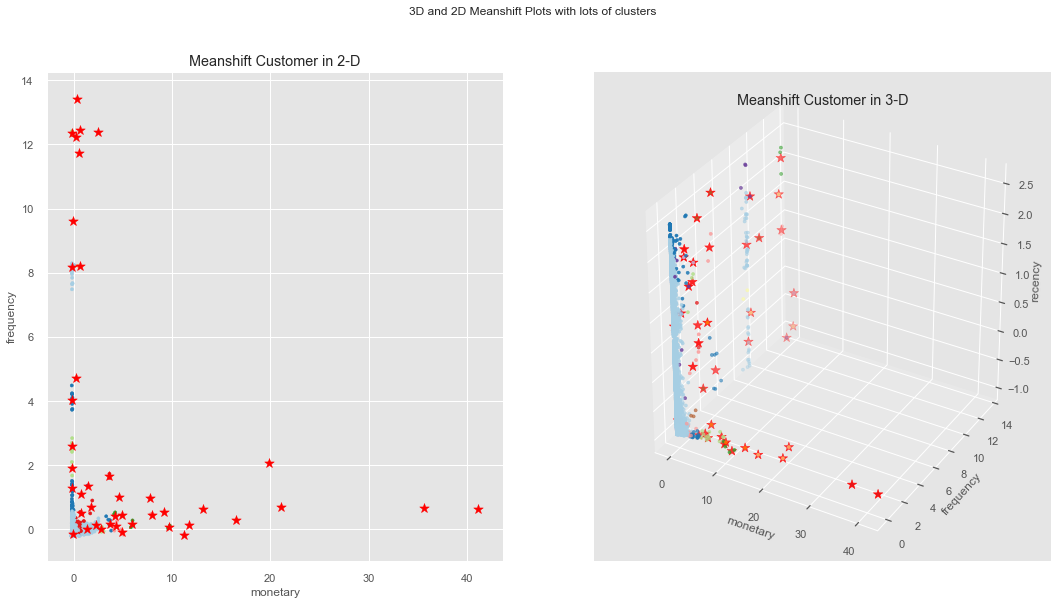

In [48]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Meanshift Plots with lots of clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.scatter(C2D[:, 0], C2D[:, 1], marker='*', c='red', s=100)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Meanshift Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.scatter(C3D[:, 0], C3D[:, 1], C3D[:, 2], marker='*', c='red', s=100)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Meanshift Customer in 3-D')

plt.show()

43 clusters is too many clusters and impossible to interprete so lets restrict the number of cluster

In [49]:
# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(sales_scaled, quantile=0.9, n_samples=5870)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(sales_scaled)
labels3D = ms.labels_
C3D = ms.cluster_centers_
labels_unique = np.unique(labels3D)
n_clusters_ = len(labels_unique)

print("number of estimated clusters 3D : %d" % n_clusters_)

# #############################################################################

bandwidth = estimate_bandwidth(sales_scaled2, quantile=0.5, n_samples=5870)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(sales_scaled2)
labels2D = ms.labels_
C2D = ms.cluster_centers_
labels_unique2 = np.unique(labels2D)
n_clusters_2 = len(labels_unique2)

print("number of estimated clusters 2D : %d" % n_clusters_2)

# #############################################################################


number of estimated clusters 3D : 9
number of estimated clusters 2D : 37


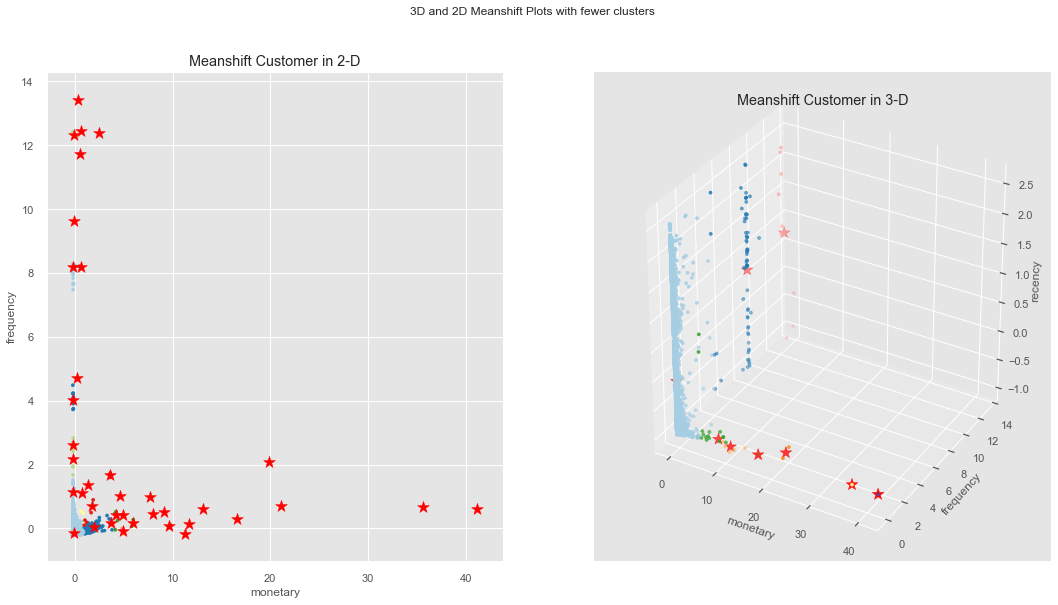

In [50]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Meanshift Plots with fewer clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.scatter(C2D[:, 0], C2D[:, 1], marker='*', c='red', s=150)
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Meanshift Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.scatter(C3D[:, 0], C3D[:, 1], C3D[:, 2], marker='*', c='red', s=150)
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Meanshift Customer in 3-D')

plt.show()

## Gaussian Mixture Models


A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

In [51]:
# Applying the basic GMM model using the previous number of cluster which is 9
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=9).fit(sales_scaled)
labels3D = gmm.predict(sales_scaled)
#######################################################################

gmm = GaussianMixture(n_components=9).fit(sales_scaled2)
labels2D = gmm.predict(sales_scaled2)

#######################################################################

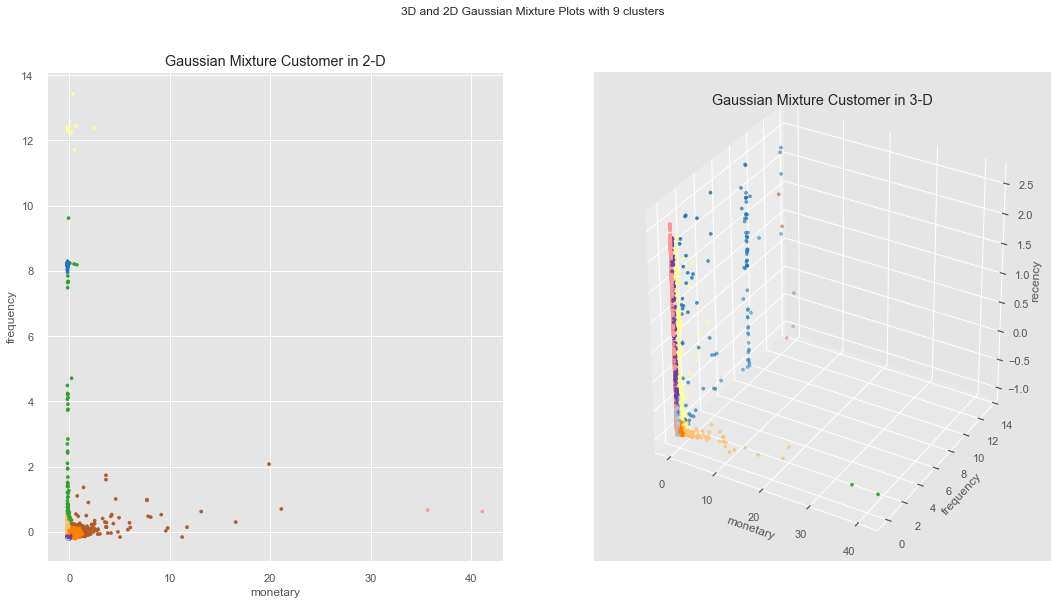

In [52]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Gaussian Mixture Plots with 9 clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Gaussian Mixture Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Gaussian Mixture Customer in 3-D')

plt.show()

## Determining the number of components using AIC and BIC
We can correct over-fitting by adjusting the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC)

In [53]:
n_components = np.arange(1, 50)
models3D = [GaussianMixture(n, covariance_type='full', random_state=0).fit(sales_scaled)
          for n in n_components]
models2D = [GaussianMixture(n, covariance_type='full', random_state=0).fit(sales_scaled)
          for n in n_components]

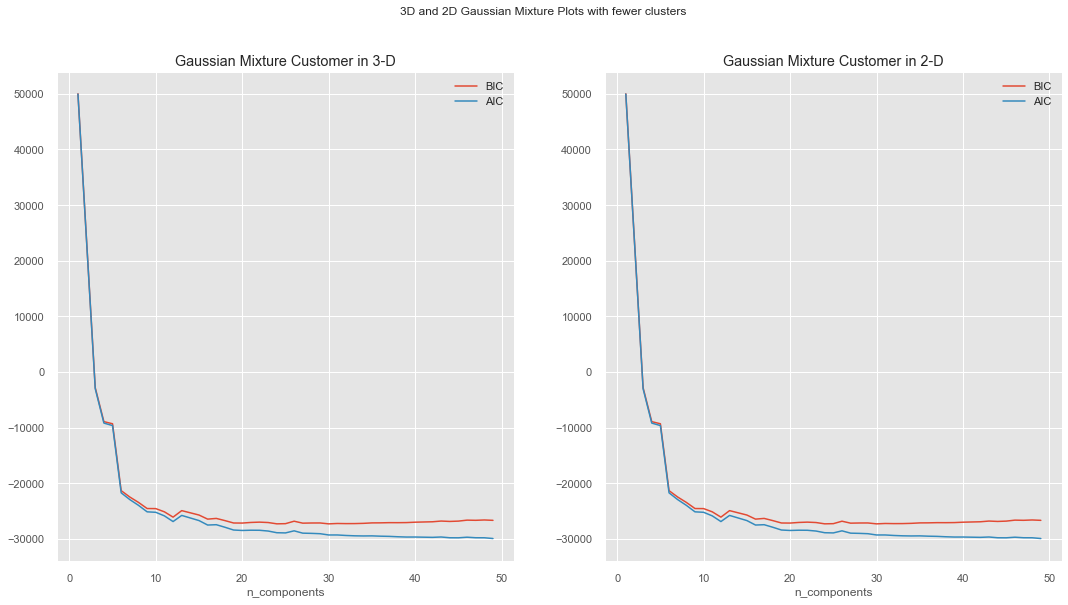

In [54]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Gaussian Mixture Plots with fewer clusters')

d3 = fig.add_subplot(1, 2, 1)
d3.plot(n_components, [m.bic(sales_scaled) for m in models3D], label='BIC')
d3.plot(n_components, [m.aic(sales_scaled) for m in models3D], label='AIC')
d3.legend(loc='best')
d3.set_xlabel('n_components')
d3.set_title('Gaussian Mixture Customer in 3-D');

d2 = fig.add_subplot(1, 2, 2)
d2.plot(n_components, [m.bic(sales_scaled) for m in models2D], label='BIC')
d2.plot(n_components, [m.aic(sales_scaled) for m in models2D], label='AIC')
d2.legend(loc='best')
d2.set_xlabel('n_components')
d2.set_title('Gaussian Mixture Customer in 2-D');

plt.show()

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. Both the AIC and BIC shows that the optimum value is between 40- 50 components which is way too much and difficult to interpret as seen in the Meanshift clustering model so I will probably take the previous deep in the line graph which is between 10 and 20 components.

In [55]:
# lets plot the 40 component GMM
gmm = GaussianMixture(n_components=40).fit(sales_scaled)
labels3D = gmm.predict(sales_scaled)
########################################################################################

# lets plot the 40 component GMM
gmm = GaussianMixture(n_components=40).fit(sales_scaled2)
labels2D = gmm.predict(sales_scaled2)
########################################################################################

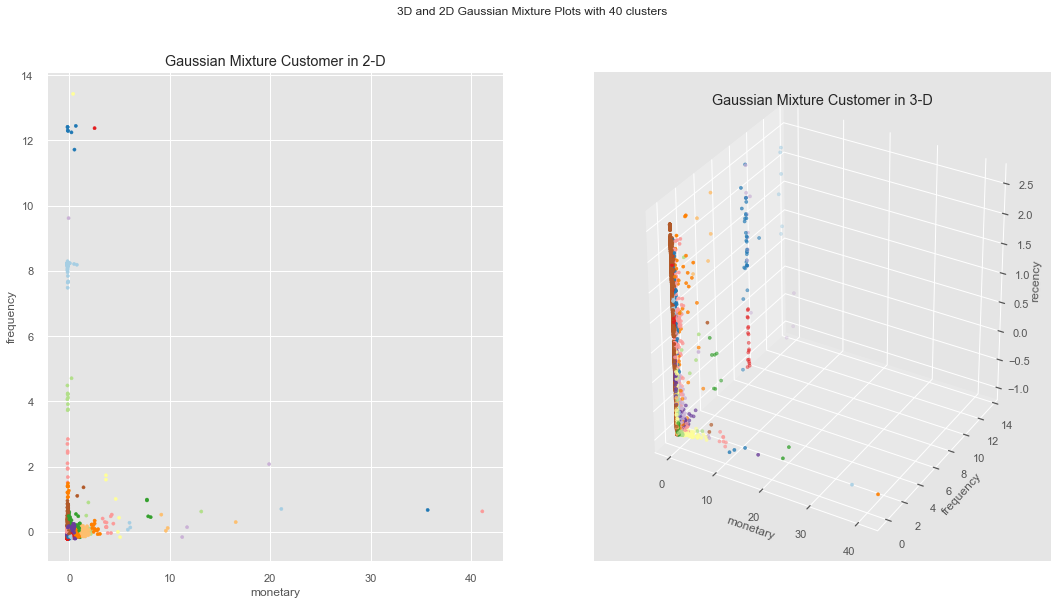

In [56]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D Gaussian Mixture Plots with 40 clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
d2.set_title('Gaussian Mixture Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')
d3.set_title('Gaussian Mixture Customer in 3-D')

plt.show()

## DBSCAN Clustering

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

In [57]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
# Generate sample data

# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=3).fit(sales_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels3D = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels3D)) - (1 if -1 in labels3D else 0)
n_noise_ = list(labels3D).count(-1)

print('3D Estimated number of clusters: %d' % n_clusters_)
print('3D Estimated number of noise points: %d' % n_noise_)
print("3D Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sales_scaled, labels3D))
############################################################################################
db = DBSCAN(eps=0.4, min_samples=3).fit(sales_scaled2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels2D = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels2D)) - (1 if -1 in labels2D else 0)
n_noise_ = list(labels2D).count(-1)

print('2D Estimated number of clusters: %d' % n_clusters_)
print('2D Estimated number of noise points: %d' % n_noise_)
print("2D Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sales_scaled2, labels2D))

3D Estimated number of clusters: 8
3D Estimated number of noise points: 64
3D Silhouette Coefficient: 0.433
2D Estimated number of clusters: 6
2D Estimated number of noise points: 32
2D Silhouette Coefficient: 0.917


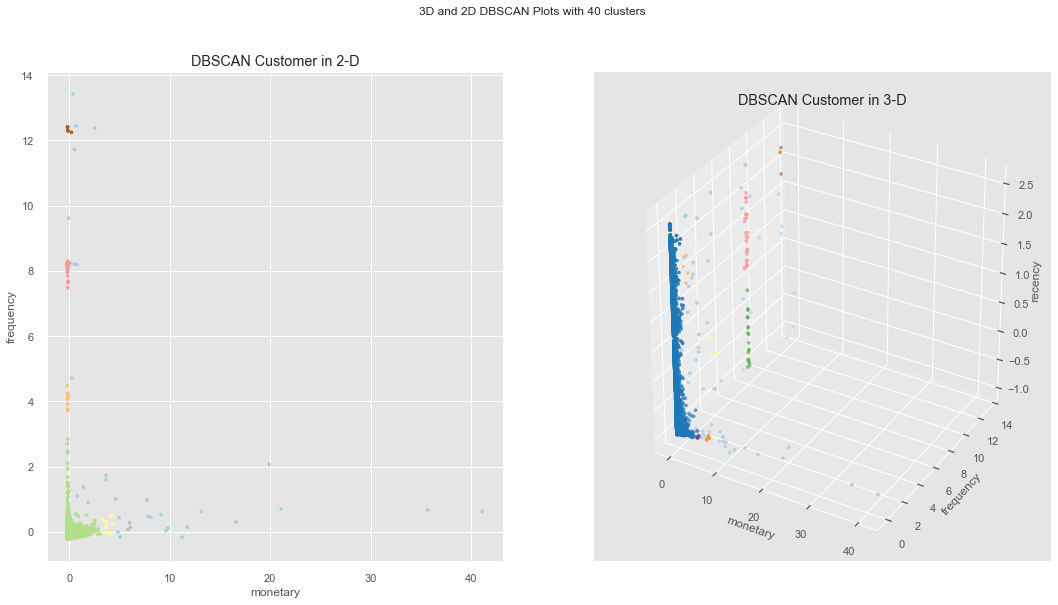

In [58]:
# Plot the output 
fig = plt.figure(figsize=(18, 9))
fig.suptitle('3D and 2D DBSCAN Plots with 40 clusters')

# First subplot
d2 = fig.add_subplot(1, 2, 1)
d2.scatter(sales_scaled2[:, 0], sales_scaled2[:, 1], c=labels2D, s=10, cmap='Paired')
d2.set_xlabel('monetary')
d2.set_ylabel('frequency')
#d2.legend(loc='best')
d2.set_title('DBSCAN Customer in 2-D')

# Second subplot
d3 = fig.add_subplot(1, 2, 2, projection='3d')
d3.scatter(sales_scaled[:, 0], sales_scaled[:, 1], sales_scaled[:, 2], c=labels3D, s=10, cmap='Paired')
d3.set_xlabel('monetary')
d3.set_ylabel('frequency')
d3.set_zlabel('recency')

d3.set_title('DBSCAN Customer in 3-D')

plt.show()

## Conclusion

From the previous RFM analysis(https://www.kaggle.com/odezi45/customer-segmentation-using-rfm-analysis), we can deduce that classifying customers into 9 clusters is more viable and easily explained, The various clustering method plots also show the somewhat distinct clusters.
It is now up to Marketting Managers, Customer Insight teams to determine what sort of communication or promotion strategy to employ in otther to convert customers from one segment to the other or maybe push more customer to a new segment preferably towards the top right corner of plots.

for more information on the advantages and disadvantages of the clustering techniques please refer to https://www.analytixlabs.co.in/blog/types-of-clustering-algorithms/